# Machine Learning now

In [3]:
import pandas as pd
import os
import numpy as np
import sklearn 
import scipy.linalg as scplinag
from sklearn.neighbors import KDTree
from scipy.spatial import distance
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

In [4]:
%matplotlib inline

# Whole dataset and 100 NN 

Attributes as in Weinmann, 2013, plus relative height (Weinmann, 2014) 

In [5]:
# Define a data frame with all my data# Define  
FILE_PATH = r"../DATA"
FILE_NAME = r"/5_Data_ML_attributes_100NN.txt"
IMAGE_FILE_PATH = r"images"
df = pd.read_csv(FILE_PATH+FILE_NAME, delimiter=',')
df.rename(index=str, columns={"range": "relative_height"}, inplace = True)
df.head()

,X,Y,Z,class,lambda1,lambda2,lambda3,lambda4,lambda5,lambda6,lambda7,lambda8,local_density,radius_neighbourhood,relative_height,verticality
0,1905.494751,21122.037109,38.884586,2,0.102637,0.896414,0.000949,0.000250,0.999051,0.030035,0.005013,0.000500,2939.715359,0.201671,-2.497189,0.000847
1,1905.502930,21122.035156,38.883110,2,0.090709,0.908312,0.000979,0.000255,0.999021,0.030308,0.005067,0.000512,3304.676763,0.193955,-2.498982,0.000847
2,1905.512939,21122.033203,38.883949,2,0.124330,0.874710,0.000960,0.000248,0.999040,0.029584,0.004924,0.000512,3681.928229,0.187091,-2.498448,0.000847
3,1905.520874,21122.031250,38.882137,2,0.180508,0.818550,0.000941,0.000248,0.999059,0.029577,0.004925,0.000517,4059.958026,0.181094,-2.500576,0.000847
4,1905.531128,21122.029297,38.882839,2,0.220828,0.778263,0.000909,0.000249,0.999091,0.029796,0.004971,0.000511,4672.880330,0.172802,-2.500191,0.000902


In [6]:
rows, cols = df.shape
print "Number of instances", rows
print "Number of attributes", cols

Number of instances 11052294
Number of attributes 16


In [7]:
# Get rid of any NaNs or Inf / -Inf values 
df.replace([np.inf, -np.inf], np.nan, inplace = True)
# Test whether there are any NAN values in the data set 
if df.isnull().values.any() == False:
    print "No Nan in this data set"

No Nan in this data set


### I have made a mistake with the class names, therefore I need to re-name them now

In the file 3_CreateFinalClasses, I did not change the names of the classes properly. Therefore, I will have to re-name them now. 

Manually, not to confuse it.

In [8]:
# Road (second most points)
df["class"].where(df["class"] != 2, 1, inplace=True)
# Sidewalk
df["class"].where(df["class"] != 3, 2, inplace=True)
# Curb
df["class"].where(df["class"] != 4, 3, inplace=True)
# Building (most points)
df["class"].where(df["class"] != 5, 4, inplace=True)
# Other pole like objects
df["class"].where(df["class"] != 6, 5, inplace=True)
# Small poles
df["class"].where(df["class"] != 7, 6, inplace=True)
# Pedestrians
df["class"].where(df["class"] != 11, 7, inplace=True)
# 2 wheelers
df["class"].where(df["class"] != 12, 8, inplace=True)
# 4 wheelers
df["class"].where(df["class"] != 13, 9, inplace=True)
# Trees
df["class"].where(df["class"] != 14, 10, inplace=True)
# Potted plants
df["class"].where(df["class"] != 15, 11, inplace=True)

In [9]:
df['class'].value_counts()

4     6359799
1     3230632
2      884203
9      318893
10     105205
3       59854
8       39803
7       23070
6       18024
11       8969
5        3842
Name: class, dtype: int64

## Describe the dataset

Describe the values and then export the file as Descriptor_Table to txt

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11052294 entries, 0 to 11052293
Data columns (total 16 columns):
X                       float64
Y                       float64
Z                       float64
class                   int64
lambda1                 float64
lambda2                 float64
lambda3                 float64
lambda4                 float64
lambda5                 float64
lambda6                 float64
lambda7                 float64
lambda8                 float64
local_density           float64
radius_neighbourhood    float64
relative_height         float64
verticality             float64
dtypes: float64(15), int64(1)
memory usage: 1.4+ GB


In [11]:
# Describe it 
descriptor_table = df.describe()
descriptor_table.to_csv(FILE_PATH+'/Descriptor_Table_10NN.txt', index= True)
descriptor_table

,X,Y,Z,class,lambda1,lambda2,lambda3,lambda4,lambda5,lambda6,lambda7,lambda8,local_density,radius_neighbourhood,relative_height,verticality
count,1.105229e+07,1.105229e+07,1.105229e+07,1.105229e+07,1.105229e+07,1.105229e+07,1.105229e+07,1.105229e+07,1.105229e+07,1.105229e+07,1.105229e+07,1.105229e+07,1.105229e+07,1.105229e+07,1.105229e+07,1.105229e+07
mean,1.902170e+03,2.122209e+04,4.107707e+01,3.189004e+00,2.220814e-01,7.455257e-01,3.239294e-02,1.710584e-03,9.676071e-01,5.661942e-02,1.240191e-02,1.758538e-02,1.803256e+04,1.435122e-01,6.328907e-01,8.334727e-01
std,5.672591e+00,6.058488e+01,3.908901e+00,1.866948e+00,1.700459e-01,1.982498e-01,6.920504e-02,4.949577e-03,6.920504e-02,5.578464e-02,2.191819e-02,3.532944e-02,1.416418e+04,8.273417e-02,4.002956e+00,6.343752e-01
min,1.885748e+03,2.112071e+04,3.666582e+01,1.000000e+00,1.751148e-05,2.891087e-05,0.000000e+00,0.000000e+00,5.729854e-02,-2.773113e+00,1.340477e-03,0.000000e+00,1.775883e-01,5.097837e-02,-3.973492e+00,1.000000e-06
25%,1.898891e+03,2.116849e+04,3.823697e+01,1.000000e+00,1.008165e-01,6.518543e-01,6.315106e-04,2.231669e-04,9.696996e-01,2.766760e-02,4.536518e-03,3.473818e-04,5.930991e+03,9.619436e-02,-2.404022e+00,1.417800e-02
50%,1.902271e+03,2.121777e+04,3.949983e+01,4.000000e+00,1.747756e-01,8.091562e-01,1.769565e-03,4.141318e-04,9.982304e-01,3.781967e-02,6.576781e-03,9.833080e-04,1.582383e+04,1.150731e-01,-9.467090e-01,9.917630e-01
75%,1.906592e+03,2.127548e+04,4.242671e+01,4.000000e+00,2.983422e-01,8.864228e-01,3.030037e-02,1.489433e-03,9.993685e-01,6.165845e-02,1.190060e-02,1.729781e-02,2.708844e+04,1.596008e-01,2.150309e+00,1.048504e+00
max,1.916770e+03,2.132869e+04,6.039886e+01,1.100000e+01,9.999660e-01,9.997526e-01,9.427015e-01,6.434519e-01,1.000000e+00,1.045629e+00,3.299874e+00,3.236199e-01,1.820015e+05,5.139720e+00,1.967205e+01,1.999999e+00


## Create feature data frame with only the features I would like to have for ML and also the class

In [12]:
df_features = df.iloc[:,3:]
df_features.drop(['radius_neighbourhood'], axis = 1, inplace = True)
df_features.head()

,class,lambda1,lambda2,lambda3,lambda4,lambda5,lambda6,lambda7,lambda8,local_density,relative_height,verticality
0,1,0.102637,0.896414,0.000949,0.000250,0.999051,0.030035,0.005013,0.000500,2939.715359,-2.497189,0.000847
1,1,0.090709,0.908312,0.000979,0.000255,0.999021,0.030308,0.005067,0.000512,3304.676763,-2.498982,0.000847
2,1,0.124330,0.874710,0.000960,0.000248,0.999040,0.029584,0.004924,0.000512,3681.928229,-2.498448,0.000847
3,1,0.180508,0.818550,0.000941,0.000248,0.999059,0.029577,0.004925,0.000517,4059.958026,-2.500576,0.000847
4,1,0.220828,0.778263,0.000909,0.000249,0.999091,0.029796,0.004971,0.000511,4672.880330,-2.500191,0.000902


In [13]:
df_features.columns

Index([u'class', u'lambda1', u'lambda2', u'lambda3', u'lambda4', u'lambda5',
       u'lambda6', u'lambda7', u'lambda8', u'local_density',
       u'relative_height', u'verticality'],
      dtype='object')

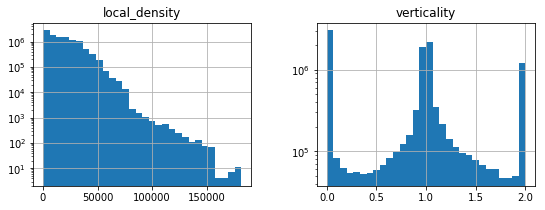

In [43]:
# Here: create the histograms manu
df_features[['local_density', 'verticality']].hist(bins=30,figsize = (9,3), log = True),
plt.savefig(IMAGE_FILE_PATH+'/Histo_10NN_6.png')
plt.show()

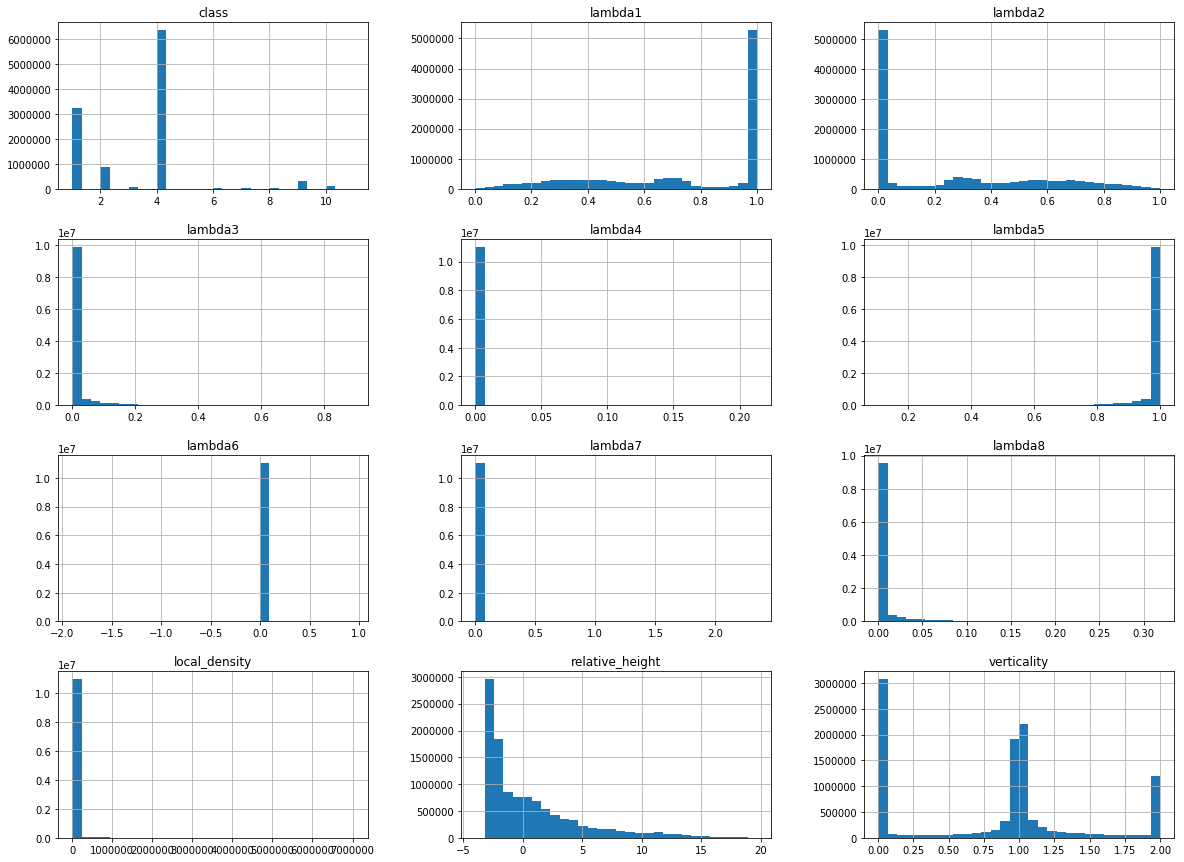

In [54]:
df_features.hist(bins = 30, figsize = (20,15)),
plt.savefig(IMAGE_FILE_PATH+'/Histo_Attribtes_10NN.png')
plt.show();

In [50]:
# This is interesting for comparing lambda 1, 2, 3 and we expect them to be correlated really 
scatter_matrix(df_features.iloc[:,1:4], figsize=(12,8)), 
plt.savefig(IMAGE_FILE_PATH+'/Scattermatrix_10NN_l1l2l3.png')
plt.show();

KeyboardInterrupt: 

## Check class distribution 

Classes:
    
1: Road - 2: Sidewalk - 3: Curb - 4: Building - 5: Other pole-like objects etc



In [51]:
# Delete the datadrame 
df = None

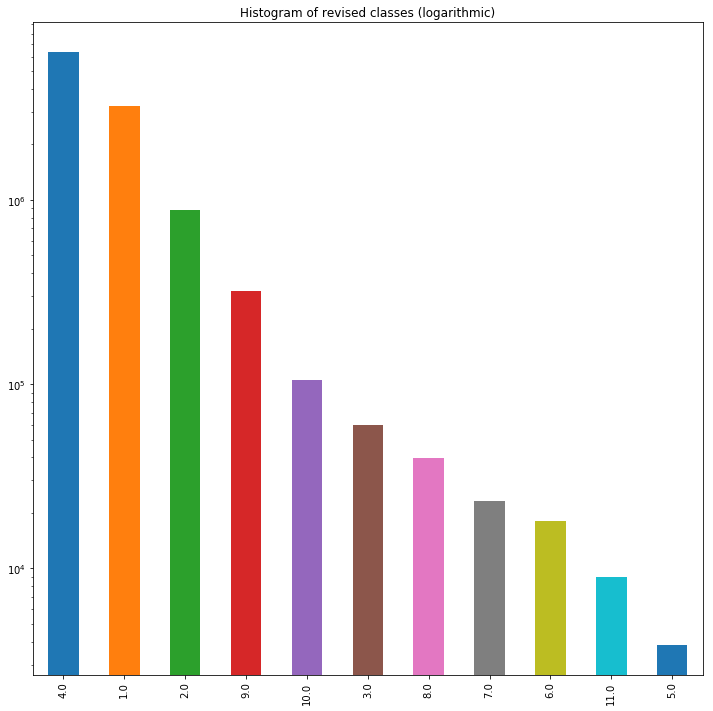

In [52]:
fig = plt.figure(figsize=(12,12))
df_features['class'].value_counts().plot(kind='bar', logy=True, title="Histogram of revised classes (logarithmic)"), plt.show();
# Save the full figure...
fig.savefig(IMAGE_FILE_PATH+'/Histo_classes.png')

# Now part for all datasets 
Until here, was only for prep and text

## Create a test set of data 

Create test set for later 

1) Just take 20% of all data, but I will use stratified sampling which is more representative 

Take the df_features dataset, it has classes and features and we stratify with respect to classes


In [53]:
from sklearn.model_selection import StratifiedShuffleSplit

In [54]:
# Convert the two columns ID and CLASS into integer values
df_features = df_features.astype({"class": 'float64'})
df_features.head()

,class,lambda1,lambda2,lambda3,lambda4,lambda5,lambda6,lambda7,lambda8,local_density,relative_height,verticality
0,1.0,0.102637,0.896414,0.000949,0.000250,0.999051,0.030035,0.005013,0.000500,2939.715359,-2.497189,0.000847
1,1.0,0.090709,0.908312,0.000979,0.000255,0.999021,0.030308,0.005067,0.000512,3304.676763,-2.498982,0.000847
2,1.0,0.124330,0.874710,0.000960,0.000248,0.999040,0.029584,0.004924,0.000512,3681.928229,-2.498448,0.000847
3,1.0,0.180508,0.818550,0.000941,0.000248,0.999059,0.029577,0.004925,0.000517,4059.958026,-2.500576,0.000847
4,1.0,0.220828,0.778263,0.000909,0.000249,0.999091,0.029796,0.004971,0.000511,4672.880330,-2.500191,0.000902


In [57]:
data = df_features.values
X = data[:,1:]
y = data[:,0]
print data.shape
print X.shape
print y.shape
print max(y)

(11052294, 12)
(11052294, 11)
(11052294,)
11.0


In [58]:
split = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
for train_index, test_index in split.split(X, y):
    # Do that here
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [59]:
print "Size X training data", X_train.shape
print "Size y training data", y_train.shape
print "Size X testing data", X_test.shape
print "Size y testing data", X_test.shape

Size X training data (8841835, 11)
Size y training data (8841835,)
Size X testing data (2210459, 11)
Size y testing data (2210459, 11)


In [75]:
# Save all my data as NUMPY arrays
# To load them later
# np.loadtxt()
np.savetxt(FILE_PATH+'/y_train_100NN.txt', y_train, delimiter=',')
np.savetxt(FILE_PATH+'/y_test_100NN.txt', y_test, delimiter=',')
np.savetxt(FILE_PATH+'/X_train_100NN.txt', X_train, delimiter=',')
np.savetxt(FILE_PATH+'/X_test_100NN.txt', X_test, delimiter=',')

In [76]:
# Compute correlation matrices to show dependencies
corr_matrix = df_features.corr()
corr_matrix.to_csv(FILE_PATH+'/corr_matrix_100NN.txt', index= True)

In [79]:
# Clean variables I domnt need right now

df = None
corr_matrix = None
X = None
y = None
data = None 